In [1]:
import pandas as pd
import numpy as np

#Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer


# Boosting classifiers
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Save model
import pickle
import joblib

In [2]:
# fileLocation = 'C:\\Users\\VictorY\\Desktop\\TestData\\stage3FinalProcessedDF_Nov-17-2019.csv'
directorDataFileLocation = 'C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\cumulativeDirectorDF_Mar-21-2020.csv'
saveFileToPath = "C:\\Yuva\\ITU\\4th Sem\\Thesis\\Data\\"

director_data = pd.read_csv(directorDataFileLocation)

In [3]:
director_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41629 entries, 0 to 41628
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   director_ids              41629 non-null  object 
 1   director_name             41629 non-null  object 
 2   movies_produced           41629 non-null  int64  
 3   Average_rating_value      41629 non-null  float64
 4   Average_rating_count      41629 non-null  float64
 5   career_Length             41629 non-null  int64  
 6   Gender                    41629 non-null  object 
 7   birthYear                 41629 non-null  int64  
 8   primaryProfession         41629 non-null  object 
 9   knownForTitles            41629 non-null  object 
 10  CareerStartYear           41629 non-null  int64  
 11  median_inter_event_time   41629 non-null  float64
 12  average_movie_per_year    41629 non-null  float64
 13  average_inter_event_time  41629 non-null  float64
dtypes: flo

## Movie classes

### One hot encoding for Gender

In [4]:
# one hot encoding of Gender
director_data = pd.concat([director_data, pd.get_dummies(director_data.Gender,prefix='Gender',dtype = int)],axis=1)
director_data.drop(['Gender'],axis=1, inplace=True)
director_data.head(2)

,director_ids,director_name,movies_produced,Average_rating_value,Average_rating_count,career_Length,birthYear,primaryProfession,knownForTitles,CareerStartYear,median_inter_event_time,average_movie_per_year,average_inter_event_time,Gender_Female,Gender_Male
0,nm0000005,Ingmar Bergman,70,7.36,6984.76,63,1918,"writer,director,actor","tt0083922,tt0069467,tt0050986,tt0050976",1946,1.0,1.11,0.9,0,1
1,nm0000008,Marlon Brando,1,7.20,7002.00,1,1924,"actor,soundtrack,director","tt0047296,tt0078788,tt0070849,tt0068646",1961,0.0,1.00,0.0,0,1


In [5]:
def balance_gender(dataframe):
    female_list_unique_directors = dataframe[(dataframe['Gender'] == 'Female')].director_ids.unique().tolist()
    
    unique_male_directors = dataframe[(dataframe['Gender'] == 'Male')].director_ids.unique().tolist()
    
    male_list_unique_directors = np.random.choice(unique_male_directors, replace = False, size = len(female_list_unique_directors)).tolist()
    
    total_list_unique_directors = female_list_unique_directors + male_list_unique_directors

    dataframe = dataframe[dataframe['director_ids'].isin(np.array(total_list_unique_directors).tolist())]

    return dataframe

In [6]:
# Generic function to equally max split the dataframe with respect to the column Name, in our case the Gender column.

def max_equal_split_on_columnName(df,columnName='director_class'):
    df1 = pd.DataFrame()
    for i in df[columnName].value_counts().index:
        df1 = df1.append(df[(df[columnName]==i)]
                         .sample(n=df[columnName]
                                 .value_counts()
                                 .values.min()
                                 ,replace = False)
                        )        
    return df1.reset_index(drop=True)

In [7]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [8]:
def print_feature_importances(coef, names, top=-1):
    whole = []
    imp = coef
    imp,names = zip(*sorted(list(zip(imp, names)),reverse=True))
    for i in range(len(names)):
        string = "{} :: {}".format(str(names[i]),str(round(imp[i],3)))
        whole.append(string)
    return whole

# Functions : Bin Cuts , Quartile Bins and bins as in paper

## Bin Cuts

In [9]:
def bincuts(df,class_feature = 'rating_value'):
    
    # Bin cuts into 4 buckets

    bin_quartiles = ['terrible','poor','average','excellent']
    cutIntoQuartiles = pd.cut(df[class_feature].to_list(), bins = 4 ,labels=bin_quartiles)

    # Print the quartile range for visuals
    print(cutIntoQuartiles.categories)

    # Add the data to the dataframe
    df['director_class'] = cutIntoQuartiles
    print('The shape of our Movies dataset is:', df.shape)
    df.drop(columns = [class_feature] , inplace = True)
    print('The shape of our Movies dataset is:', df.shape)

## Quartile Bins

In [10]:
def quartile_bin(df,class_feature='rating_value'):
    # Quartile cut into 4 different buckets

    bin_quartiles = ['terrible','poor','average','excellent']
    cutIntoQuartiles = pd.qcut(df[class_feature].to_list(), q=4,labels=bin_quartiles)
    
    print(cutIntoQuartiles.categories)
    
    df['director_class'] = cutIntoQuartiles
    print('The shape of our dataset before dropping the class feature is:', df.shape)
    df.drop(columns = [class_feature] , inplace = True)
    print('The shape of our dataset after dropping the class feature  is:', df.shape)
    return df

## Paper Implementation of bins

In [11]:
def success_measure(score):
    
    if score > 0 and score <= 2.4:
        return 'poor'
#     elif score > 2.4 and score <= 5.0:a
        return 'average'
    elif score > 5.0 and score <= 7.4:
        return 'good'
    elif score > 7.4 and score <=10.0:
        return 'excellent'
    else:
        return 'Error_Score'

# Function - To choose which Success measure to choose and what binning technique

In [12]:
def choose_success_measure(df, bin_method = 'q_cut', feature = 'rating_value'):
    
    # Stats of the feature
    print('\nDescribing the feature : \n')
    print(df[feature].describe())
    

    
    if (bin_method == 'q_cut'):
        # Quartie bin cuts
        df = quartile_bin(df,feature)
            
    elif(bin_method == 'bin_cut'):
        # Bin cuts
        movies_data = bincuts(movies_data,feature)
        
    elif(bin_method == 'aspaper_cut'):
        df['director_class'] = df[feature].apply(success_measure).astype('category')
        
        print('\nShape of the dataset : \n')
        print('\nThe shape of our Director dataset is:', df.shape)
        df.drop(columns = [feature] , inplace = True)
        print('\nThe shape of our Director dataset is:', df.shape)
    
    print('\nValue Count of the bucketed class is : \n')
    print(df['director_class'].value_counts())

# Weighted Rank

In [13]:
# Weighted ranking value
# IMDB uses this famous formula:
# weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

# Where:

# R = average for the movie (mean) = (rating)

# v = number of votes for the movie = (votes)

# m = minimum votes required to be listed in the Top Rated list (currently 25,000)

# C = the mean vote across the whole report

In [14]:
def weightedRank(df,R='Average_rating_value', v='Average_rating_count', m = 100):
#     df = df.loc[df[v] > m ]
    df['weighted_rank'] = (df[v] / (df[v] + m )) * df[R] + (m / ( df[v] + m)) * df[R].mean()
    return df

In [15]:
minVotes =  director_data['Average_rating_count'].quantile(0.5)
minVotes

34.0

### Bin Cuts

In [16]:
# # Quartie bin on Weighted rating value
# movies_data = bincuts(movies_data,'weighted_rank')

### Quartile Bins

In [17]:
# movies_data.rating_count.describe()

In [18]:
# movies_data = weightedRank( movies_data, m = minVotes )

# # Quartie bin on Weighted rating value

# movies_data.drop(columns = 'rating_value',inplace = True)
# movies_data = quartile_bin(movies_data,'weighted_rank')

### Paper Implementation of bins

In [19]:
# movies_data['director_class'] = movies_data['weighted_rank'].apply(success_measure).astype('category')
# print('The shape of our Movies dataset is:', movies_data.shape)# print('The shape of our Movies dataset is:', movies_data.shape)
# movies_data.drop(columns = ['weighted_rank'] , inplace = True)
# print('The shape of our Movies dataset is:', movies_data.shape)

In [20]:
director_data.columns.values

array(['director_ids', 'director_name', 'movies_produced',
       'Average_rating_value', 'Average_rating_count', 'career_Length',
       'birthYear', 'primaryProfession', 'knownForTitles',
       'CareerStartYear', 'median_inter_event_time',
       'average_movie_per_year', 'average_inter_event_time',
       'Gender_Female', 'Gender_Male'], dtype=object)

## Run the feature based on the bin cut and success feature

In [21]:
choose_success_measure(director_data , bin_method = 'q_cut' , feature = 'Average_rating_count')


Describing the feature : 

count     41629.000000
mean       1398.390829
std       11699.252139
min           5.000000
25%          12.670000
50%          34.000000
75%         147.890000
max      690249.000000
Name: Average_rating_count, dtype: float64
Index(['terrible', 'poor', 'average', 'excellent'], dtype='object')
The shape of our dataset before dropping the class feature is: (41629, 16)
The shape of our dataset after dropping the class feature  is: (41629, 15)

Value Count of the bucketed class is : 

poor         10477
terrible     10432
excellent    10407
average      10313
Name: director_class, dtype: int64


In [22]:
# director_data = director_data[director_data['movie_class'].isin(['poor','excellent'])]

### Remove Features from dataset which are not required

In [23]:
# # Unique director distribution in max_equal DF
# print("Unique director distribution - movies_data split based on Gender")

# movies_data.drop_duplicates(subset = 'director_ids', keep = 'first').Gender.value_counts()

In [24]:
object_features_to_remove = director_data.select_dtypes(include = 'object').columns.values
object_features_to_remove

array(['director_ids', 'director_name', 'primaryProfession',
       'knownForTitles'], dtype=object)

### Unbalanced Director Dataset

In [25]:
# important_features = ['director_known_titles_average_rating_value',
#        'director_profession_secondary', 'director_profession_tertiary',
#        'genre_Animation', 'genre_Family', 'genre_Mystery',
#        'genre_Thriller', 'rating_count', 'review_count_user']

# important_features.remove('rating_count')
# important_features.extend(['movie_class'])

In [26]:
print('The shape of our Unbalanced director dataset before:', director_data.shape)
director_data = director_data[director_data.columns.difference(object_features_to_remove)]
print('The shape of our Unbalanced director dataset after dropping object features:', director_data.shape)

# director_data.drop(columns = ['Gender_Male','Gender_Female'],inplace = True)
# print('The shape of our Unbalanced director dataset after dropping Gender:', director_data.shape)

# director_data = director_data[important_features]
# # director_data = director_data[director_data.columns.difference(important_features)]
# print('The shape of our Unbalanced director dataset after dropping all but important features:', director_data.shape)

The shape of our Unbalanced director dataset before: (41629, 15)
The shape of our Unbalanced director dataset after dropping object features: (41629, 11)


In [27]:
director_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41629 entries, 0 to 41628
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Average_rating_value      41629 non-null  float64 
 1   CareerStartYear           41629 non-null  int64   
 2   Gender_Female             41629 non-null  int32   
 3   Gender_Male               41629 non-null  int32   
 4   average_inter_event_time  41629 non-null  float64 
 5   average_movie_per_year    41629 non-null  float64 
 6   birthYear                 41629 non-null  int64   
 7   career_Length             41629 non-null  int64   
 8   director_class            41629 non-null  category
 9   median_inter_event_time   41629 non-null  float64 
 10  movies_produced           41629 non-null  int64   
dtypes: category(1), float64(4), int32(2), int64(4)
memory usage: 2.9 MB


In [28]:
director_data['director_class'].value_counts()

poor         10477
terrible     10432
excellent    10407
average      10313
Name: director_class, dtype: int64

### Visualize

### Balanced Director Dataset

In [29]:
balanced_director_data = max_equal_split_on_columnName(director_data)

In [30]:
# balanced_director_data = balanced_director_data[req_columns]
print('The shape of our Balanced Director dataset is:', balanced_director_data.shape)

The shape of our Balanced Director dataset is: (41252, 11)


In [31]:
balanced_director_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41252 entries, 0 to 41251
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Average_rating_value      41252 non-null  float64 
 1   CareerStartYear           41252 non-null  int64   
 2   Gender_Female             41252 non-null  int32   
 3   Gender_Male               41252 non-null  int32   
 4   average_inter_event_time  41252 non-null  float64 
 5   average_movie_per_year    41252 non-null  float64 
 6   birthYear                 41252 non-null  int64   
 7   career_Length             41252 non-null  int64   
 8   director_class            41252 non-null  category
 9   median_inter_event_time   41252 non-null  float64 
 10  movies_produced           41252 non-null  int64   
dtypes: category(1), float64(4), int32(2), int64(4)
memory usage: 2.9 MB


In [32]:
balanced_director_data['director_class'].value_counts()

excellent    10313
average      10313
poor         10313
terrible     10313
Name: director_class, dtype: int64

# Observations

In [33]:
# Function to Plot - Distribution of rating value among male and female. 

def plot_features_WRT_gender(df,columnCriteriaName,columnFeatureName):
    dict={}
    for i in df[columnCriteriaName].value_counts().index:
        dict["{0}_{1}".format(columnFeatureName,i)] = df[(df[columnCriteriaName] == i)][columnFeatureName]
    for k,v in dict.items():
        sns.distplot(v,label=[k])
        plt.legend(bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)

## Divide the data to training and testing - Scaling methods too

Check about the Scaling

In [34]:
def divide_test_train_with_scaling_methods(df,predict='director_class',scalingMethod = "MinMaxScaler"):
    
    
    # Feature matrix and target variable
    X = df.drop(predict,axis = 'columns')
    y = df[predict]
    
    # Scaling
    if (scalingMethod == "MinMaxScaler"):
        print("The scaling method used is : ",scalingMethod)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X)
        # X_test = scaler.transform(X_test)
        
    else:
        print("No Scaling Method used or incorrect input")
        X_train = X
    
    # Divide the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.20, random_state = 42 )
    
    return X_train, X_test, y_train, y_test

In [35]:
# Divide the data into training and test

X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(director_data,scalingMethod="None")
# X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(director_data,scalingMethod="MinMaxScaler")

No Scaling Method used or incorrect input


In [48]:
X_train

,Average_rating_value,CareerStartYear,Gender_Female,Gender_Male,average_inter_event_time,average_movie_per_year,birthYear,career_Length,median_inter_event_time,movies_produced
31964,6.80,2004,0,1,0.00,1.00,1978,1,0.0,1
13631,6.54,1917,1,0,3.50,0.33,1874,15,3.5,5
6666,6.78,2007,0,1,2.67,0.44,1981,9,2.0,4
32039,5.77,2012,0,1,0.80,1.20,1978,5,0.0,6
33901,5.55,1921,0,1,3.00,0.50,1886,4,3.0,2
...,...,...,...,...,...,...,...,...,...,...
6265,7.04,1961,0,1,3.00,0.38,1921,13,3.0,5
11284,7.11,1994,0,1,0.81,1.23,1964,22,0.0,27
38158,4.95,2009,1,0,1.00,1.00,1976,2,1.0,2
860,5.67,1959,0,1,0.97,1.03,1932,30,1.0,31


In [36]:
# # Divide the data into training and test

# X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(balanced_director_data,scalingMethod="None")
# X_train, X_test, y_train, y_test = divide_test_train_with_scaling_methods(balanced_director_data,scalingMethod="MinMaxScaler")

# Plot Confusion Matrix

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Boosting Classifiers

### 1.  Gradient Boosting Classifier

#### 1a) Identify the optimal Learning rate

In [38]:
# optimal_learning_rate = learningRateDF['learning_rate'].loc[learningRateDF.
#                                                                 mask((learningRateDF == learningRateDF.min())
#                                                                      .cumsum()
#                                                                      .astype(bool))
#                                                                 [::-1]
#                                                                 .idxmax()
#                                                                 ['testing_accuracy']]

In [39]:
def optimal_learning_rate(X_train, X_test, y_train, y_test):
    
    lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

    col_learningDF = ['learning_rate','training_accuracy','testing_accuracy']
    learningRateDF = pd.DataFrame(columns=col_learningDF)

    for learning_rate in lr_list:

        gb_clf = GradientBoostingClassifier(n_estimators=100,
                                            learning_rate=learning_rate,
                                            max_leaf_nodes= 32,
                                            max_features=2,
                                            max_depth=2,
                                            random_state= 42 )
        gb_clf.fit(X_train, y_train)

        accuracy_train_score = gb_clf.score(X_train, y_train)
        accuracy_test_score = gb_clf.score(X_test, y_test)

        learningRateDF.loc[len(learningRateDF)] = [learning_rate,accuracy_train_score,accuracy_test_score]
#         print("Learning rate: ", learning_rate)
#         print("Accuracy score (training): {0:.3f}".format(accuracy_train_score))
#         print("Accuracy score (test): {0:.3f}".format(accuracy_test_score))
    print(learningRateDF)

    optimal_learning_rate = learningRateDF['learning_rate'].loc[learningRateDF.testing_accuracy.argmax()]

# # Script to find the maximum learning_rate where the test_accuracy is maximum

#     optimal_learning_rate = learningRateDF['learning_rate'].loc[((learningRateDF == learningRateDF.min())
#                                                                  .cumsum()
#                                                                  .astype(bool))
#                                                                 [::-1].idxmax()
#                                                                 ['testing_accuracy']
#                                                                ]

    return optimal_learning_rate

In [40]:
chosen_learning_rate_GB = optimal_learning_rate(X_train, X_test, y_train, y_test)
print("\nThe optimal learning rate for XGB Classifier is :",chosen_learning_rate_GB)

   learning_rate  training_accuracy  testing_accuracy
0          0.050           0.424136          0.411722
1          0.075           0.425487          0.413764
2          0.100           0.429211          0.416166
3          0.250           0.434946          0.416527
4          0.500           0.443864          0.419769
5          0.750           0.449539          0.421091
6          1.000           0.451731          0.421811

The optimal learning rate for XGB Classifier is : 1.0


#### 1b) Model Function

In [41]:
def train_model_Gradient_Boosting_classifier(X_train, X_test, y_train, y_test,learning_rate = 1):
    
    labelDirectorClass = ['terrible','poor','average','excellent']
    
    
    # Classifier parameters    
    gb_clf2 = GradientBoostingClassifier(n_estimators=100,
                                         learning_rate=learning_rate,
                                         max_leaf_nodes= 32,
                                         max_features=2,
                                         max_depth=2,
                                         random_state= 42
                                        )
    gb_clf2.fit(X_train, y_train)
    
    # Predict classes
    y_pred = gb_clf2.predict(X_test)
    
    cnf_matrix = confusion_matrix(y_test, y_pred,labels= labelDirectorClass )
#     np.set_printoptions(precision=2)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes= labelDirectorClass,
                      title='Confusion matrix, without normalization')
    
    
    gb_train_score = gb_clf2.score(X_train, y_train)
    print("Training Score of Gradient Boosting Classifier: ",round(gb_train_score,3))
    
    gb_test_score = gb_clf2.score(X_test, y_test)
    print("\nTesting Score of Gradient Boosting Classifier : ",round(gb_test_score,3))

#     print("\nConfusion Matrix:\n")
#     print(cnf_matrix)

    print("\nClassification Report\n")
#     print(classification_report(y_test, y_pred))
    print(classification_report(y_test, y_pred, labels = labelDirectorClass ))
    
    # Performance metrics
    
#     print( "Overall Precision score : ",round(metrics.precision_score(y_test, y_pred, average='macro'),3))
#     print( "\nOverall Recall score : ",round(metrics.recall_score(y_test, y_pred, average='macro'),3))
    print( "\nAUC : ",round(multiclass_roc_auc_score(y_test, y_pred),3))
    print( "Matthews_corrcoef : ", round(metrics.matthews_corrcoef(y_test, y_pred),3))
       
    return gb_clf2

#### 1c) Run Results of Gradient Boosting Model

Confusion matrix, without normalization
[[1429  305  150  170]
 [ 936  468  311  424]
 [ 559  330  467  710]
 [ 393  192  334 1148]]
Training Score of Gradient Boosting Classifier:  0.452

Testing Score of Gradient Boosting Classifier :  0.422

Classification Report

              precision    recall  f1-score   support

    terrible       0.43      0.70      0.53      2054
        poor       0.36      0.22      0.27      2139
     average       0.37      0.23      0.28      2066
   excellent       0.47      0.56      0.51      2067

    accuracy                           0.42      8326
   macro avg       0.41      0.42      0.40      8326
weighted avg       0.41      0.42      0.40      8326


AUC :  0.616
Matthews_corrcoef :  0.237


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=1.0, loss='deviance', max_depth=2,
                           max_features=2, max_leaf_nodes=32,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

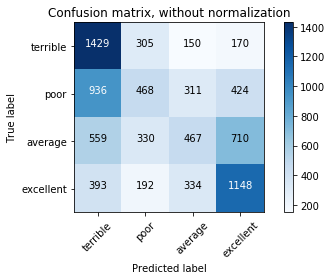

In [42]:
train_model_Gradient_Boosting_classifier(X_train, X_test, y_train, y_test,learning_rate = chosen_learning_rate_GB)
# tn, fp, fn, tp

### 2. XGB Classifier

#### 2b) Optimal learning rate

In [43]:
def optimal_learning_rate_xgb(X_train, X_test, y_train, y_test):
    
    lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

    col_learningDF = ['learning_rate','training_accuracy','testing_accuracy']
    learningRateDF = pd.DataFrame(columns=col_learningDF)

    for learning_rate in lr_list:

        xgb_clf = XGBClassifier(n_estimators=100,
                                learning_rate=learning_rate,
                                max_leaf_nodes= 32,
                                max_features=2,
                                max_depth=2,
                                random_state= 42
                               )
        
        xgb_clf.fit(X_train, y_train)

        accuracy_train_score = xgb_clf.score(X_train, y_train)
        accuracy_test_score = xgb_clf.score(X_test, y_test)

        learningRateDF.loc[len(learningRateDF)] = [learning_rate,accuracy_train_score,accuracy_test_score]
#         print("Learning rate: ", learning_rate)
#         print("Accuracy score (training): {0:.3f}".format(accuracy_train_score))
#         print("Accuracy score (test): {0:.3f}".format(accuracy_test_score))
    print(learningRateDF)

    optimal_learning_rate = learningRateDF['learning_rate'].loc[learningRateDF.testing_accuracy.argmax()]

# # Script to find the maximum learning_rate where the test_accuracy is maximum

#     optimal_learning_rate = learningRateDF['learning_rate'].loc[((learningRateDF == learningRateDF.min())
#                                                                  .cumsum()
#                                                                  .astype(bool))
#                                                                 [::-1].idxmax()
#                                                                 ['testing_accuracy']
#                                                                ]

    return optimal_learning_rate

In [44]:
chosen_learning_rate_XGB = optimal_learning_rate_xgb(X_train, X_test, y_train, y_test)
print("\nThe optimal learning rate for XGB Classifier is :",chosen_learning_rate_XGB)

   learning_rate  training_accuracy  testing_accuracy
0          0.050           0.419272          0.408960
1          0.075           0.424406          0.411362
2          0.100           0.427739          0.411482
3          0.250           0.435757          0.416406
4          0.500           0.445485          0.421211
5          0.750           0.452572          0.423012
6          1.000           0.455755          0.418088

The optimal learning rate for XGB Classifier is : 0.75


#### 2b) Model Function

In [45]:
def train_model_XGB_classifier(X_train, X_test, y_train, y_test,learning_rate = 1):
    
    labelDirectorClass = ['terrible','poor','average','excellent']
    
    # Classifier parameters    

    xgb_clf = XGBClassifier(n_estimators=100,
                            learning_rate=learning_rate,
                            max_leaf_nodes= 32,
                            max_features=2,
                            max_depth=2,
                            random_state= 42
                           )
    
    xgb_clf.fit(X_train, y_train)
    
    # Predict classes
    y_pred = xgb_clf.predict(X_test)
    
    cnf_matrix = confusion_matrix(y_test, y_pred,labels= labelDirectorClass )
    np.set_printoptions(precision=2)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes= labelDirectorClass,
                      title='Confusion matrix, without normalization')
    
    xgb_train_score = xgb_clf.score(X_train, y_train)
    print("\nTraining Score : ",round(xgb_train_score,3))
    
    xgb_test_score = xgb_clf.score(X_test, y_test)
    print("\nTesting Score : ",round(xgb_test_score,3))

#     print("\nConfusion Matrix:\n")
#     print(cnf_matrix)

    print("\nClassification Report\n")
    print(classification_report(y_test, y_pred, labels = labelDirectorClass ))
    
    # Performance metrics
    
#     print( "Overall Precision score : ",round(metrics.precision_score(y_test, y_pred, average='macro'),3))
#     print( "\nOverall Recall score : ",round(metrics.recall_score(y_test, y_pred, average='macro'),3))
    print( "\nAUC : ",round(multiclass_roc_auc_score(y_test, y_pred),3))
    print( "Matthews_corrcoef : ", round(metrics.matthews_corrcoef(y_test, y_pred),3))
    
    return xgb_clf

###  2c) Run results of XGB Model

Confusion matrix, without normalization
[[1438  289  167  160]
 [ 941  471  303  424]
 [ 574  339  428  725]
 [ 395  198  289 1185]]

Training Score :  0.453

Testing Score :  0.423

Classification Report

              precision    recall  f1-score   support

    terrible       0.43      0.70      0.53      2054
        poor       0.36      0.22      0.27      2139
     average       0.36      0.21      0.26      2066
   excellent       0.48      0.57      0.52      2067

    accuracy                           0.42      8326
   macro avg       0.41      0.43      0.40      8326
weighted avg       0.41      0.42      0.40      8326


AUC :  0.617
Matthews_corrcoef :  0.24


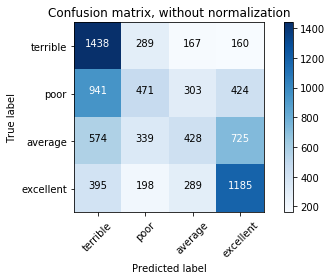

In [46]:
xgb_clf = train_model_XGB_classifier(X_train, X_test, y_train, y_test,learning_rate = chosen_learning_rate_XGB)
# tn, fp, fn, tp

In [47]:
break

SyntaxError: 'break' outside loop (<ipython-input-47-6aaf1f276005>, line 4)

# END

## Feature Importance

In [ ]:
X_test.columns.values

In [ ]:
feature_imp_xgb = xgb_clf.feature_importances_

In [ ]:
feature_imp_xgb

In [ ]:
feature_imp_xgb[feature_imp_xgb>0.05]

In [ ]:
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

In [ ]:
from xgboost import plot_importance

In [ ]:
# plot feature importance
plot_importance(xgb_clf)

## Feature selection of XGB

In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
# select features using threshold
selection = SelectFromModel(estimator = xgb_clf, threshold='median', prefit=True)
select_X_train = selection.transform(X_train)

In [ ]:
# train model
selection_model = XGBClassifier(n_estimators = 100,
                                learning_rate = 0.1,
                                max_leaf_nodes = 32,
                                max_features = 2,
                                max_depth = 2,
                                random_state = 42
                                )

selection_model.fit(select_X_train, y_train)

In [ ]:
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

In [ ]:
labelMovieClass = ['poor','average','good','excellent']
print("Classification Report")
print(classification_report(y_test, y_pred, labels = labelMovieClass ))

In [ ]:
# Feature importance based on contribution to the classifier model
print("\nAbsolute contributions\n")
absoluteListOrder = print_feature_importances(abs(trainedSVClassifier.coef_[0]), featuresSelected)
for j in absoluteListOrder:
    print(j)

In [ ]:
print("\nPositive and Negative contributions\n")
listOrder = print_feature_importances((trainedSVClassifier.coef_[0]), featuresSelected)
for i in listOrder:
    print(i)

# End